# MNIST classification

Install TensorFlow Quantum:

In [2]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/tomas/Escritorio/TFG/quantum_env/lib/python3.8/site-packages/pkg_resources/__init__.py'>

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


5


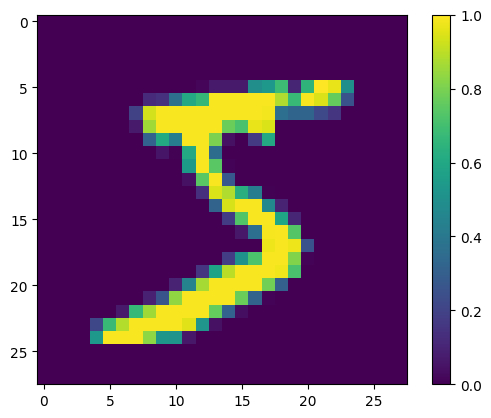

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0]) #Imagen 0 con el canal de color 0,. cogiendo todas las filas y columnas
plt.colorbar()

In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

5


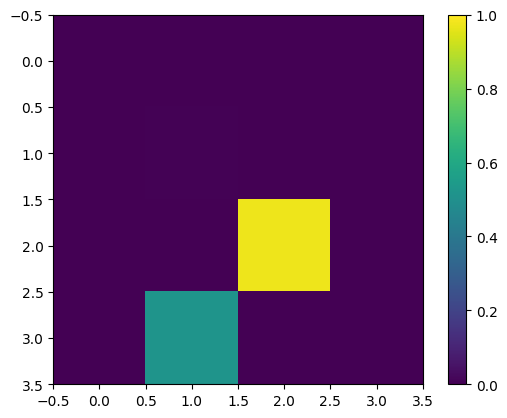

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    #num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    #num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    #num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    #print("Number of unique images:", len(mapping.values()))
    #print("Number of unique 3s: ", num_uniq_3)
    #print("Number of unique 6s: ", num_uniq_6)
    #print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    #print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Initial number of images:  60000
Remaining non-contradicting unique images:  44461


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [10]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [11]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

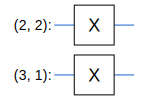

In [55]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [56]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [12]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [13]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

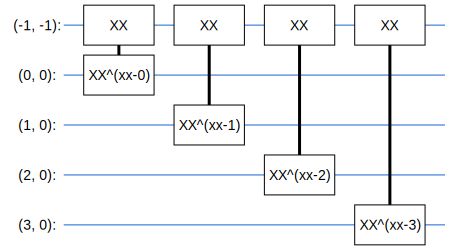

In [13]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [14]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readouts = [cirq.GridQubit(-1, -1), cirq.GridQubit(-2,-2)]         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    for readout in readouts:
        circuit.append(cirq.X(readout))
        circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [15]:
model_circuit, model_readout = create_quantum_model()

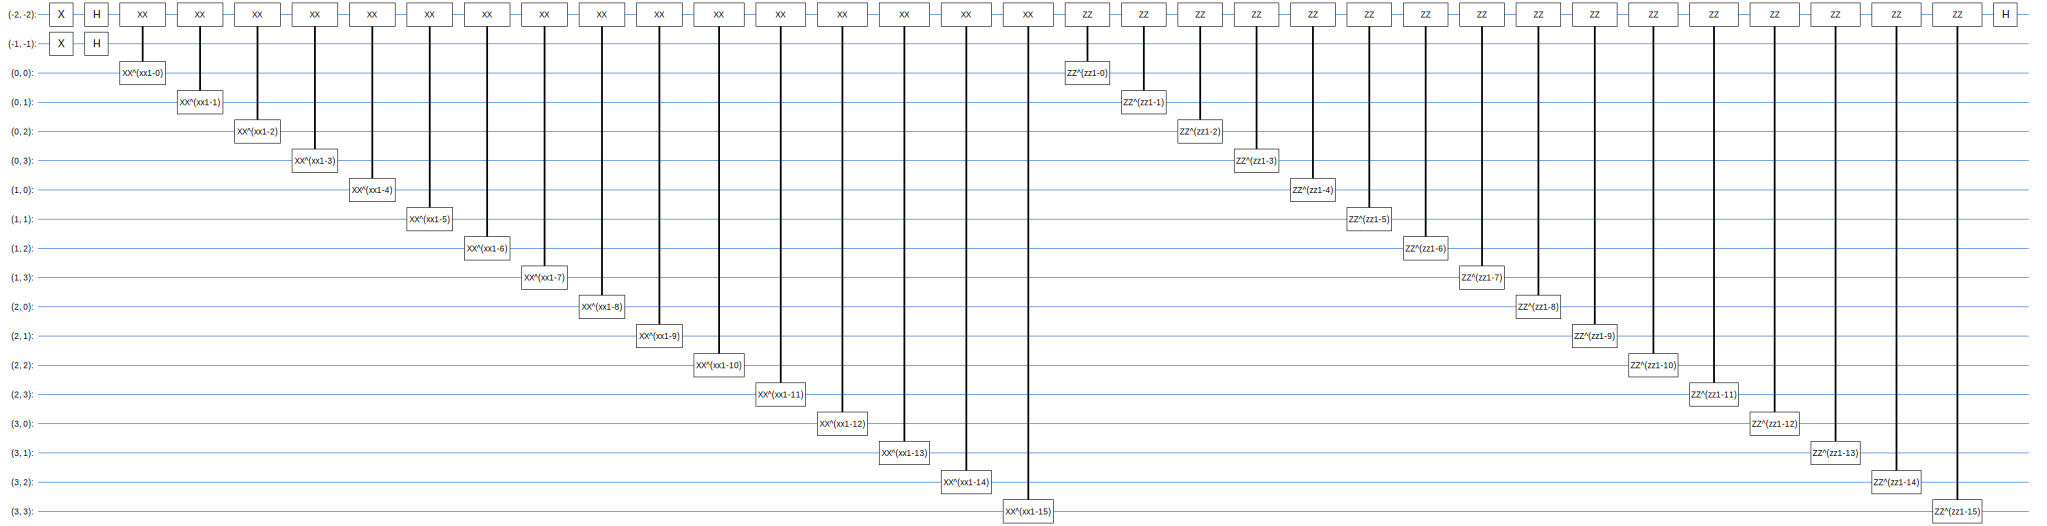

In [16]:
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [67]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [68]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [69]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [70]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [71]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [72]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [73]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [74]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
1390/1390 [==============================] - 1337s 961ms/step - loss: 0.2556 - hinge_accuracy: 0.8652 - val_loss: 0.2064 - val_hinge_accuracy: 0.9021
Epoch 2/3
1390/1390 [==============================] - 1294s 931ms/step - loss: 0.1552 - hinge_accuracy: 0.9004 - val_loss: 0.2007 - val_hinge_accuracy: 0.9021
Epoch 3/3
313/313 [==============================] - 28s 88ms/step - loss: 0.1954 - hinge_accuracy: 0.9021


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [82]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 9216)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               1179776   
                                                      

In [83]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: -1917114880.0000 - accuracy: 0.1135


In [77]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model_fair = create_fair_classical_model()
model_fair.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model_fair.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                 34        
                                                                 
 dense_11 (Dense)            (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [78]:
model_fair.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model_fair.evaluate(x_test_bin, y_test)

Epoch 1/20
348/348 - 1s - loss: 0.2504 - accuracy: 0.0995 - val_loss: -1.0003e+00 - val_accuracy: 0.0967 - 564ms/epoch - 2ms/step
Epoch 2/20
348/348 - 0s - loss: -6.8593e+00 - accuracy: 0.0408 - val_loss: -1.2337e+01 - val_accuracy: 0.1135 - 248ms/epoch - 713us/step
Epoch 3/20
348/348 - 0s - loss: -2.3403e+01 - accuracy: 0.0346 - val_loss: -2.9971e+01 - val_accuracy: 0.1135 - 241ms/epoch - 691us/step
Epoch 4/20
348/348 - 0s - loss: -4.6480e+01 - accuracy: 0.0346 - val_loss: -5.3066e+01 - val_accuracy: 0.1135 - 238ms/epoch - 685us/step
Epoch 5/20
348/348 - 0s - loss: -7.5446e+01 - accuracy: 0.0346 - val_loss: -8.1089e+01 - val_accuracy: 0.1135 - 237ms/epoch - 682us/step
Epoch 6/20
348/348 - 0s - loss: -1.0970e+02 - accuracy: 0.0346 - val_loss: -1.1359e+02 - val_accuracy: 0.1135 - 261ms/epoch - 751us/step
Epoch 7/20
348/348 - 0s - loss: -1.4878e+02 - accuracy: 0.0346 - val_loss: -1.5015e+02 - val_accuracy: 0.1135 - 248ms/epoch - 712us/step
Epoch 8/20
348/348 - 0s - loss: -1.9236e+02 - ac

## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

<AxesSubplot: >

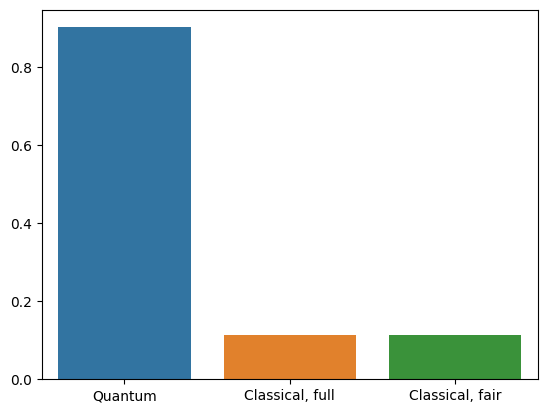

In [79]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(x=["Quantum", "Classical, full", "Classical, fair"],
            y=[qnn_accuracy, cnn_accuracy, fair_nn_accuracy])